# Ensemble: pr/prra/prsn (over sea-ice and ocean)

## Imports & defaults

In [1]:
import libs.ensemble
import libs.local
import libs.plot
import libs.vars
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

matplotlib.rcParams.update({ 'font.size': 18 })

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'Amon'
experiment = 'ssp585'
variable_id = 'pr'

conf = [v for v in libs.vars.variables() if v['variable_id'] == variable_id][0]
time_series_text = '''total precipitation (solid), rainfall (dashed), snowfall (dashdot), 
and evaporation (dotted) over sea-ice and ocean'''

time_series_weighted_method = conf['weighting_method']
time_series_units = conf['units']
time_series_y_label = f'Precipitation ({time_series_units})'
time_series_y_range = (0, 2.25)
time_series_y_range_monthly = (0, 3)
time_series_process = lambda x: x

In [3]:
ensemble_pr_time_series = time_series_process(
    libs.local.get_ensemble_series(variable_id, experiment)
)
ensemble_pr_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series(variable_id, experiment, suffix='_smooth')
)

# ----- prra -----
ensemble_prra_time_series = time_series_process(
    libs.local.get_ensemble_series('prra', experiment)
)
ensemble_prra_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series('prra', experiment, suffix='_smooth')
)
for variable in ensemble_prra_time_series:
    ensemble_prra_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }
    ensemble_prra_time_series_smooth[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }

# ----- prsn -----
ensemble_prsn_time_series = time_series_process(
    libs.local.get_ensemble_series('prsn', experiment)
)
ensemble_prsn_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series('prsn', experiment, suffix='_smooth')
)
for variable in ensemble_prsn_time_series:
    ensemble_prsn_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashdot' }
    ensemble_prsn_time_series_smooth[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashdot' }

# ----- tas -----
ensemble_tas_time_series = libs.local.get_ensemble_series('tas', experiment)
ensemble_tas_time_series_smooth = libs.local.get_ensemble_series('tas', experiment, suffix='_smooth')
ensemble_tas_time_series /= 10

# ----- evspsbl -----
ensemble_evspsbl_time_series = libs.local.get_ensemble_series('evspsbl', experiment)
ensemble_evspsbl_time_series_smooth = libs.local.get_ensemble_series('evspsbl', experiment, suffix='_smooth')

for variable in ensemble_evspsbl_time_series:
    ensemble_evspsbl_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dotted' }
    ensemble_evspsbl_time_series_smooth[variable].attrs['plot_kwargs'] = { 'linestyle': 'dotted' }


time_slices = libs.vars.default_time_slices()

## Time series

### Mean

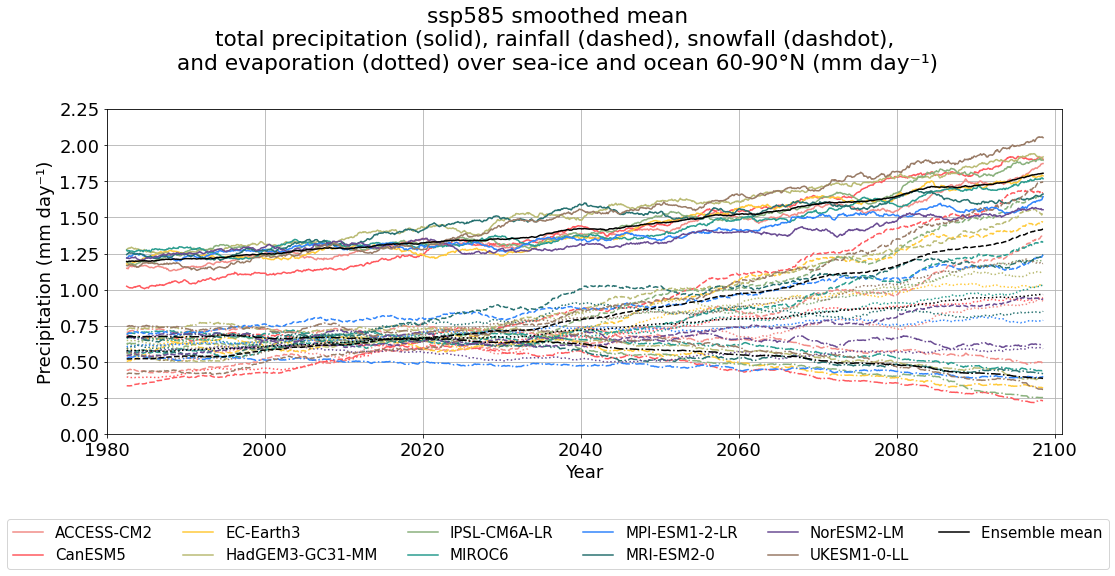

In [4]:
libs.plot.time_series_from_vars(
    [
        ensemble_pr_time_series_smooth,
        ensemble_prsn_time_series_smooth,
        ensemble_prra_time_series_smooth,
        ensemble_evspsbl_time_series_smooth
    ],
    title=f'{experiment} smoothed mean\n{time_series_text} 60-90°N ({time_series_units})',
    xattr='time',
    ylabel=time_series_y_label,
    yrange=time_series_y_range
);

## Monthly variability

### Full region (time)

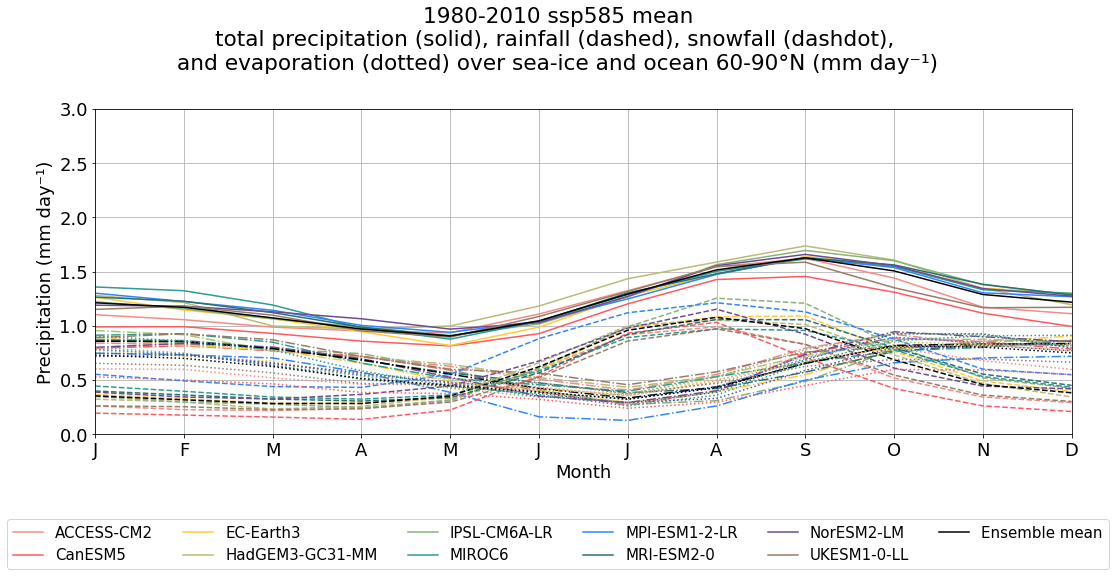

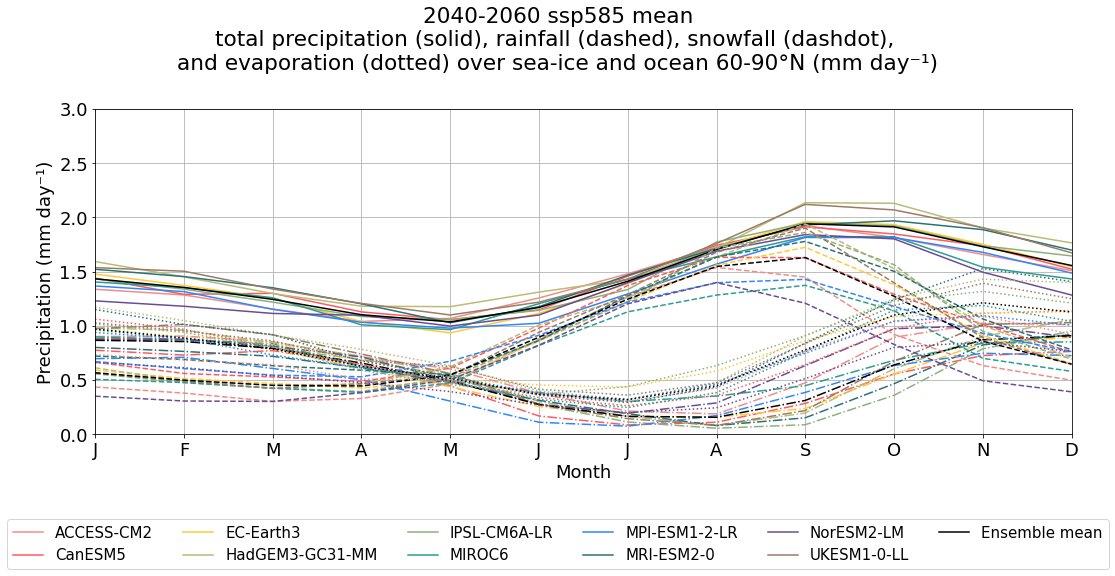

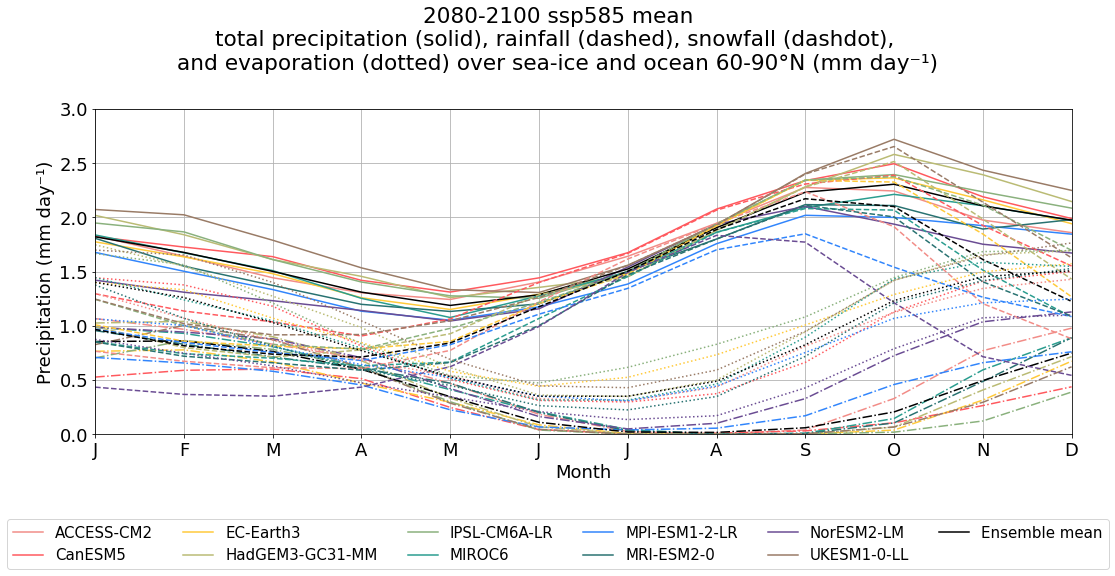

In [5]:
for s in time_slices:
    s_label = s['label']

    libs.plot.monthly_variability(
        [
            ensemble_pr_time_series.sel(**s['slice']).groupby('time.month').mean('time'),
            ensemble_prsn_time_series.sel(**s['slice']).groupby('time.month').mean('time'),
            ensemble_prra_time_series.sel(**s['slice']).groupby('time.month').mean('time'),
            ensemble_evspsbl_time_series.sel(**s['slice']).groupby('time.month').mean('time'),
        ],
        title=f'{s_label} {experiment} mean\n{time_series_text} 60-90°N ({time_series_units})',
        ylabel=time_series_y_label,
        yrange=time_series_y_range_monthly
    )

## Rain season length

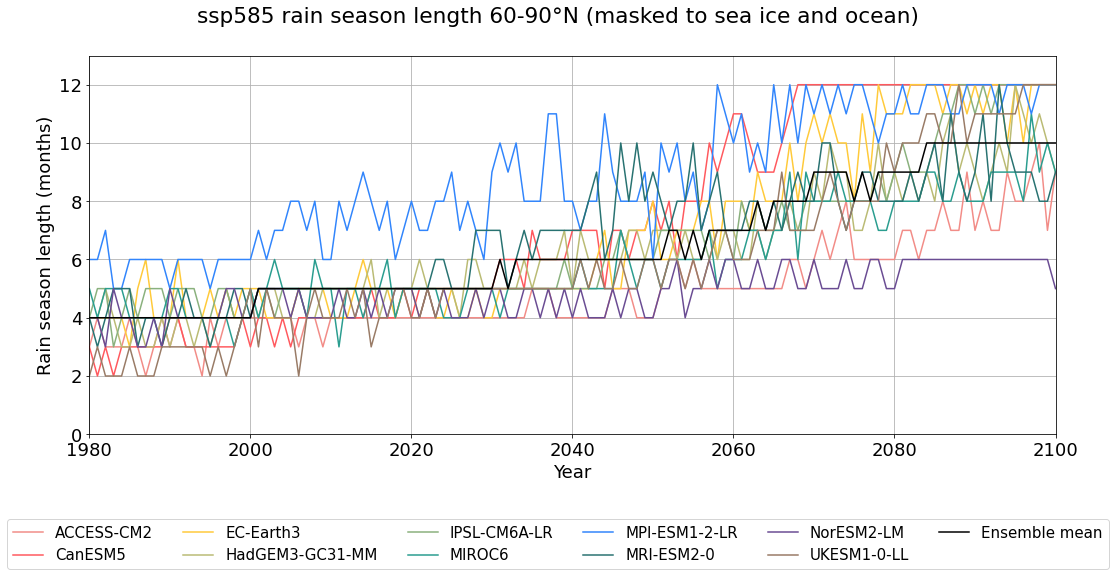

In [6]:
ensemble_rain_season_length = ensemble_pr_time_series.copy()
for key in ensemble_rain_season_length:
    ensemble_rain_season_length[key] = ensemble_rain_season_length[key]\
        .where(ensemble_prra_time_series[key] > ensemble_prsn_time_series[key])\
        .groupby('time.year')\
        .count('time')

ensemble_rain_season_length = libs.ensemble.calc_variable_mean(ensemble_rain_season_length, 'time')
ensemble_rain_season_length['Ensemble mean'] = ensemble_rain_season_length['Ensemble mean'].round()

fig = libs.plot.time_series_from_vars(
    [
        ensemble_rain_season_length
    ],
    title=f'{experiment} rain season length 60-90°N (masked to sea ice and ocean)',
    xattr='year',
    ylabel='Rain season length (months)',
    yrange=(0, 13)
);

#data = ensemble_rain_season_length
#data_min = data.to_array('time').min('time')
#data_max = data.to_array('time').max('time')

#fig.axes[0].fill_between(
#    data.year.values,
#    data_min.values,
#    data_max.values,
#    alpha=0.05,
#    color=data['Ensemble mean'].attrs['color'],
#    zorder=-1
#);

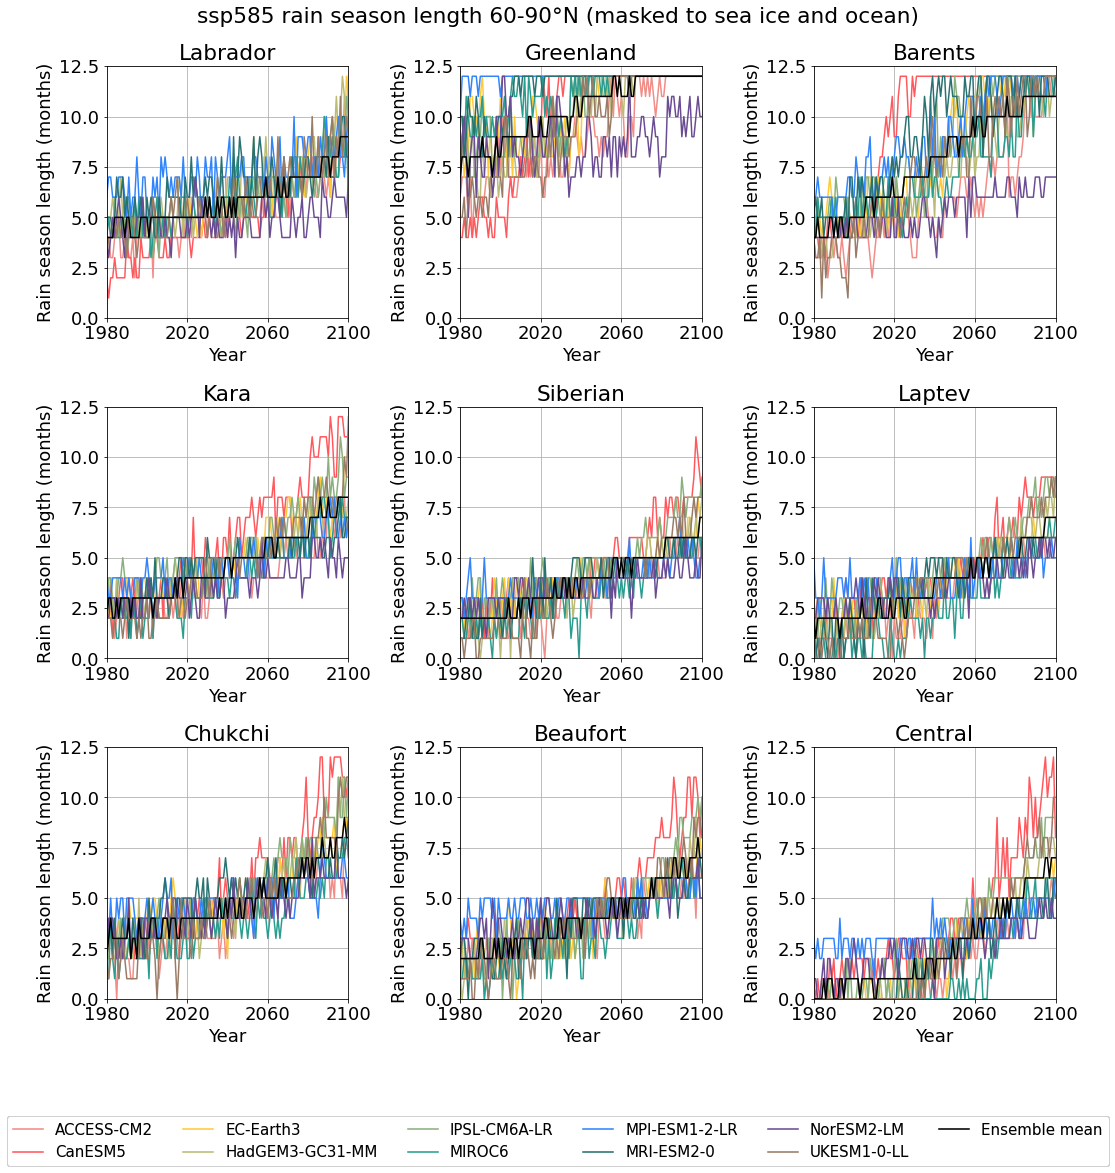

In [7]:
regions_prra = libs.local.get_ensemble_regional_series('prra', experiment)
regions_prsn = libs.local.get_ensemble_regional_series('prsn', experiment)

fig, axes = plt.subplots(*(3, 3), figsize=(15, 15))
axes = axes.flatten()
fig.suptitle(f'{experiment} rain season length 60-90°N (masked to sea ice and ocean)')

for i, data_prra in enumerate(regions_prra):
    ensemble_rain_season_length = data_prra.copy()
    data_prsn = regions_prsn[i]
    region = data_prra.attrs['region']

    for key in ensemble_rain_season_length:
        ensemble_rain_season_length[key] = ensemble_rain_season_length[key]\
            .where(data_prra[key] > data_prsn[key])\
            .groupby('time.year')\
            .count('time')

    ensemble_rain_season_length = libs.ensemble.calc_variable_mean(ensemble_rain_season_length, 'time')
    ensemble_rain_season_length['Ensemble mean'] = ensemble_rain_season_length['Ensemble mean'].round()
        
    fig = libs.plot.time_series_from_vars(
        [
            ensemble_rain_season_length
        ],
        ax=axes[i],
        fig=fig,
        xattr='year',
        ylabel='Rain season length (months)',
        yrange=(0, 12.5)
    )
    
    axes[i].set_title(region)
    axes[i].set_xticks([1980, 2020, 2060, 2100])